In [1]:
result_file = './venus/1/result.pkl'

In [73]:
import pickle
with open(result_file, 'rb') as f:
    results = pickle.load(f)

In [110]:
results[3]

([array([], shape=(0, 5), dtype=float32)], [[]])

In [79]:
import cv2
def findContours(*args, **kwargs):
    """
    Wraps cv2.findContours to maintain compatiblity between versions
    3 and 4

    Returns:
        contours, hierarchy
    """
    if cv2.__version__.startswith('4'):
        contours, hierarchy = cv2.findContours(*args, **kwargs)
    elif cv2.__version__.startswith('3'):
        _, contours, hierarchy = cv2.findContours(*args, **kwargs)
    else:
        raise AssertionError(
            'cv2 must be either version 3 or 4 to call this method')

    return contours, hierarchy

In [80]:
import pycocotools.mask as mask_util
import matplotlib.pyplot as plt
from approx_poly import approx
import numpy as np

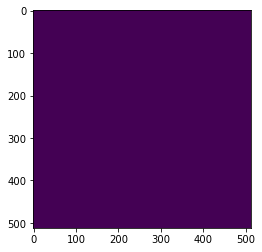

{'size': [512, 512], 'counts': b'PPP8'}


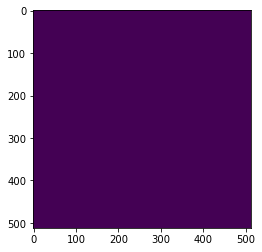

{'size': [512, 512], 'counts': b'PPP8'}


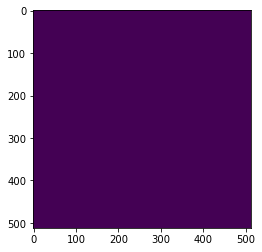

{'size': [512, 512], 'counts': b'PPP8'}


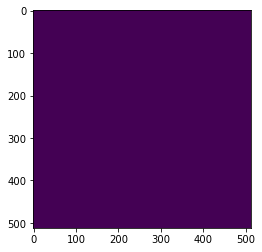

{'size': [512, 512], 'counts': b'PPP8'}


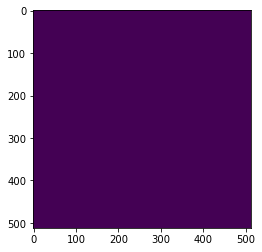

{'size': [512, 512], 'counts': b'PPP8'}


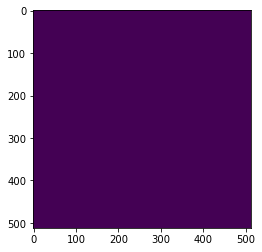

{'size': [512, 512], 'counts': b'PPP8'}


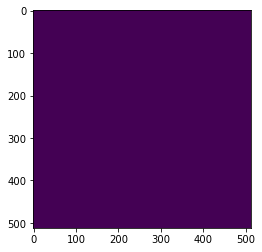

{'size': [512, 512], 'counts': b'PPP8'}


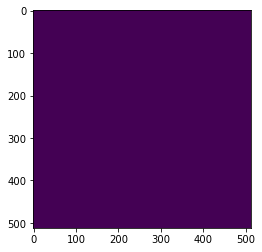

{'size': [512, 512], 'counts': b'PPP8'}


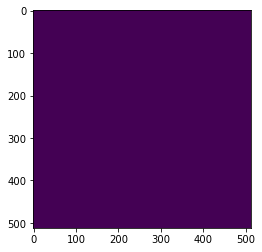

{'size': [512, 512], 'counts': b'PPP8'}


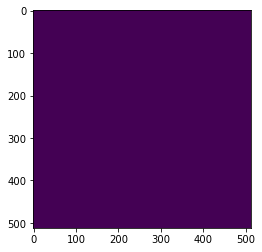

{'size': [512, 512], 'counts': b'PPP8'}


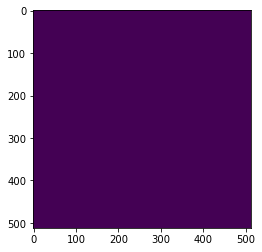

{'size': [512, 512], 'counts': b'PPP8'}


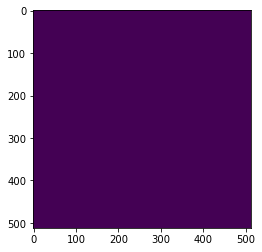

{'size': [512, 512], 'counts': b'PPP8'}


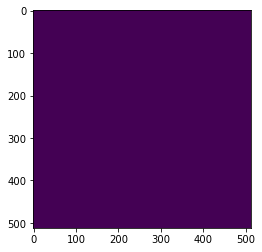

{'size': [512, 512], 'counts': b'PPP8'}


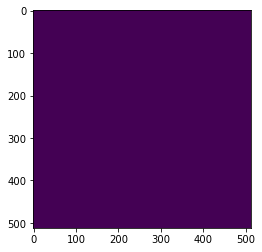

{'size': [512, 512], 'counts': b'PPP8'}


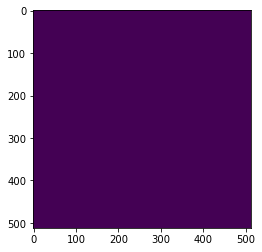

{'size': [512, 512], 'counts': b'PPP8'}


In [120]:
imgs = mask_util.decode(results[226][1][0])
c = imgs.shape[-1]
for i in range(c):
    img = imgs[:, :, [i]]
    h, w = img.shape[:2]
    plt.imshow(img)
    plt.show()
    contours, _ = findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print(results[226][1][0][i])
        continue
    contours = np.concatenate(contours, axis=0)
    
        
    contour = cv2.convexHull(contours)
    approx_polygon = True
    if approx_polygon:
        contour_ = approx(contour.copy()).reshape(-1, 2)
    else:
        contour_ = cv2.minAreaRect(contour)
        contour_ = cv2.boxPoints(contour_).astype(np.int32)
    temp_img = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(temp_img, [contour_], 1)

    plt.imshow(temp_img)
    plt.show()
    temp_img = np.array(temp_img[:, :, None], order='F', dtype='uint8')
    print(mask_util.encode(temp_img)[0])

In [124]:
import copy
from tqdm import tqdm
results_out = []
approx_polygon = True
for i in tqdm(range(len(results))[1102:1105]):
    result = results[i]
    if len(result[0][0]) == 0:
        results_out.append((result[0], [[]]))
        continue
    imgs = mask_util.decode(result[1][0])
    h, w, c = imgs.shape
    img_segm = []
    for j in range(c):
        img = imgs[:, :, [j]]
        contours, _ = findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            img_segm.append(result[1][0][j])
            continue
        contours = np.concatenate(contours, axis=0)
        contour = cv2.convexHull(contours)

        if approx_polygon:
            try:
                contour_ = approx(contour.copy()).reshape(-1, 2)
            except Exception as e:
                print(e)
                img_segm.append(result[1][0][j])
                continue
        else:
            contour_ = cv2.minAreaRect(contour)
            contour_ = cv2.boxPoints(contour_).astype(np.int32)
        temp_img = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(temp_img, [contour_], 1)
        temp_img = np.array(temp_img[:, :, None], order='F', dtype='uint8')
        img_segm.append(mask_util.encode(temp_img)[0])
    results_out.append((result[0], [img_segm]))

 33%|███▎      | 1/3 [00:01<00:03,  1.77s/it]

float division by zero


100%|██████████| 3/3 [00:16<00:00,  5.37s/it]


In [ ]:
with open('./eval_result.pkl', 'wb') as f:
    pickle.dump(results_out, f)

In [129]:
!python tools/analysis_tools/eval_metric.py venus/1/mask_rcnn_r50_fpn_1x_building.py ./venus/1/result_eval_rect.pkl --eval segm

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda/'
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!

Evaluating segm...
Loading and preparing results...
DONE (t=0.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=13.96s).
Accumulating evaluation results...
DONE (t=0.99s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.581
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.323
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.210
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.388
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.350
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=

In [9]:
!python convert_result.py --input_file venus/1/result.pkl --output_file venus/1/result_eval_poly.pkl --is_approx

100%|███████████████████████████████████████| 3509/3509 [52:48<00:00,  1.11it/s]


In [2]:
!python convert_result.py --input_file venus/1/result.pkl --output_file venus/1/result_eval_rect.pkl

100%|███████████████████████████████████████| 3509/3509 [01:01<00:00, 57.24it/s]


In [6]:
!python convert_result.py --input_file venus_last_tf/1/result.pkl --output_file venus_last_tf/1/result_eval_rect.pkl

100%|███████████████████████████████████████| 1233/1233 [01:12<00:00, 16.95it/s]


In [8]:
!python convert_result.py --input_file venus_last_tf/1/result.pkl --output_file venus_last_tf/1/result_eval_poly.pkl --is_approx

100%|███████████████████████████████████████| 1233/1233 [54:25<00:00,  2.65s/it]


In [10]:
!python tools/analysis_tools/eval_metric.py venus/1/mask_rcnn_r50_fpn_1x_building.py ./venus/1/result_eval_poly.pkl --eval segm

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda/'
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!

Evaluating segm...
Loading and preparing results...
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=18.80s).
Accumulating evaluation results...
DONE (t=1.44s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.584
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.333
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.211
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.393
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.361
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=

In [11]:
!python tools/analysis_tools/eval_metric.py venus_last_tf/1/tf_mask_rcnn_r50_fpn_1x_building.py ./venus_last_tf/1/result_eval_poly.pkl --eval segm

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda/'
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!

Evaluating segm...
Loading and preparing results...
DONE (t=0.46s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=44.59s).
Accumulating evaluation results...
DONE (t=1.80s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.574
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.274
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.247
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.377
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.410
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.455
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=